In [321]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from scipy import signal
from tools import *

from sklearn.decomposition import NMF, PCA

from scipy.sparse import *
from scipy.io import mmread 

# Import auryn tools
sys.path.append(os.path.expanduser("~/auryn/tools/python/"))
from auryntools import *
from matplotlib import animation, rc
from IPython.display import HTML
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import tools
import elephant
import quantities as pq
from neo.core import SpikeTrain
import viziphant
from pyvis.network import Network
import networkx as nx
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import plotly.io as pio
from hmmlearn import hmm
import numba 
from multiprocessing import Pool
import pandas as pd 

In [322]:
def show_hist_times(event_in_time,times,bins=100,log = False):
    
    pio.renderers.default = 'notebook'

    # plotly setup
    fig=go.Figure()

    # data binning and traces
    for i, col in enumerate(times):
        dt = np.array(event_in_time[col])
        hist = np.histogram(dt[~np.isnan(dt)], bins=bins, density=False)
        if log :
            x =np.ma.log(hist[0].tolist())
            a0=x.filled(0)
        else:
            a0=hist[0].tolist()
        
        a0=np.repeat(a0,2).tolist()
        a0.insert(0,a0[0])
        a0.pop()
        a1=hist[1].tolist()
        a1=np.repeat(a1,2)
        fig.add_traces(go.Scatter3d(x=[col]*len(a0), y=a1, z=a0,
                                    mode='lines',
                                    name=col,
                                   )
                      )
        

    fig.update_layout(
    height=700,
    )
    fig.update_layout(scene_aspectmode="manual")
    fig.update_layout(scene_aspectratio=dict(x=len(times)*0.35, y=1, z=1))

    fig.show()

In [330]:
dure_simu = 21800
begining_presentation = 0
duree_pattern = 0.1
time_step = 0.1
auryn_tstep = 0.0001
spls = dure_simu/time_step

In [324]:
deb = 100
dur = 2
beg = int(deb//time_step)
end = beg+int(dur//time_step)


In [325]:
num_mpi_ranks = 4 # the number of sims you used in parallel
datadir = os.path.expanduser("/mnt/data1/data_paul/Sim_old/sim_less_stim_neurons_nocons_suite_6h_pat") # Set this to your data path
prefix = "rf1"

nb_neurons = 4096

In [326]:
#datadir_sigal = os.path.expanduser("~/data/sim_network/sim_10Hz_cons_4h_1pat_mrco_5_demonstration") # Set this to your data path
datadir_sigal = datadir

In [327]:
all_times = np.genfromtxt(datadir_sigal+'/pattern_times', delimiter=' ')
nb_pattern = len(set(all_times[:,1]))
signals = np.zeros((nb_pattern,int(dure_simu//time_step)+1))
signals_times = [[] for i in range(nb_pattern)]
for time,kind in all_times:
    signals_times[int(kind)].append(time)
    signals[int(kind),int((time)//time_step):int((time*auryn_tstep+(duree_pattern))//time_step)]=1
signals_times = np.array(signals_times)


In [328]:
signals_times[0][-1]

21799.7907

In [331]:

spkfiles  = ["%s/%s.%i.e.spk"%(datadir,prefix,i) for i in range(0,num_mpi_ranks)]
sfo = AurynBinarySpikeView(spkfiles)

Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)
Warning! Version mismatch between the decoding tool and the file version.
AurynBinarySpikeFile (0, 8, 1)
Fileversion (0, 8, 2)


In [337]:
rateE  = np.mean([pd.read_csv("%s/%s.%i.e.prate"%(datadir,prefix,2),delimiter=' ').values for i in range(num_mpi_ranks)],axis=0)

In [338]:
len(rateE)

217999

In [339]:
time_axis = np.linspace(0,dure_simu,int(dure_simu//time_step))
rateE= rateE[:,1]


In [340]:
win = signal.windows.hann(1)
fig = go.Figure(data=go.Scatter(x=time_axis[-100000:], y=(np.convolve(rateE,win,'same')/ sum(win))[-100000:]))
fig.show()

In [248]:
def plot_profile(begin,end,title,nb_sample,nb_sample_ext,alpha = 1,signal = 0,more_than = 1000):

    tm_rast = begin
    time_range_rast = end
    beg_2 = int(tm_rast//time_step)
    end_2 = beg_2+int(time_range_rast//time_step)
    
    spikes_rast = np.array(sfo.get_spikes(t_start=tm_rast,t_stop=tm_rast+time_range_rast))

    ListTrains = [[] for _ in range(nb_neurons)] 
    for s in spikes_rast:
        ListTrains[int(s[1])].append(s[0])

    spikes_rast  = np.array([li for li in spikes_rast if len(ListTrains[int(li[1])])<more_than])
    np.random.seed(0)
    sample = np.random.choice(list(range(nb_neurons)),nb_sample)
    spikes_rast_sample = np.array([i for i in spikes_rast if i[1] in sample])

    spikes_rast_ext = np.array(sfo_ext.get_spikes(t_start=tm_rast,t_stop=tm_rast+time_range_rast))

    sample_ext = np.random.choice(list(range(nb_neurons)),nb_sample_ext)
    spikes_rast_sample_ext =np.array([i for i in spikes_rast_ext if i[1] in sample_ext])
    
    new_indexes = dict(zip(list(set(spikes_rast_sample[:,1])),list(range(nb_sample))))
    
    new_indexes_ext = dict(zip(list(set(spikes_rast_sample_ext[:,1])),list(range(nb_sample_ext))))
    
    colors = in_pattern(spikes_rast_sample_ext,duree_pattern, signals_times[0])
    colors = ["r" if i ==1 else "b" for i in colors]
    
    fig, axs = plt.subplots(3,figsize=(8,10),sharex=True,gridspec_kw={'height_ratios': [2,2, 1]})
    fig.suptitle(title,y = 0.92,fontsize = 15)
    
    axs[0].scatter(spikes_rast_sample_ext[:,0], 
                   [new_indexes_ext[i] for i in spikes_rast_sample_ext[:,1]],alpha = alpha, c =colors,s = 18)
    axs[0].set_ylabel("input neuron index",fontsize = 12)

    axs[1].scatter(spikes_rast_sample[:,0], 
                   [new_indexes[i] for i in spikes_rast_sample[:,1]],alpha = alpha, c="b",s = 18)
    axs[1].set_ylabel("output neuron index",fontsize = 12)

    some_signals = signals_times[0][ (signals_times[0]<(tm_rast+time_range_rast) ) & (signals_times[0]>tm_rast)]

    axs[2].plot(time_axis[beg_2:end_2],rateE[beg_2:end_2])

    for sig in some_signals:
        axs[2].axvspan(sig, sig+duree_pattern, facecolor='red', alpha=0.25)
    
    axs[2].set_ylabel("rate (Hz)",fontsize = 12)
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (s)",fontsize = 12)
    #plt.ylabel("common Y",x = 0)
    

In [332]:
sfo

In [333]:
number_iter = 2
time_range = 100
nb_signal = 1
size_window = 0.2
procces_number = 10
starting_time = 0

all_spikes_in_time,all_dist_in_time,all_times_in_time,all_data_in_time,times = parallelize(procces_number,number_iter,time_range,nb_signal,size_window,sfo,dure_simu,signals_times,nb_neurons,duree_pattern,starting_time)



extracting_spikes...
computing...


In [334]:
bin_size = 1e-3

In [335]:
which_signal=0
spikes_in_time = all_spikes_in_time[which_signal]
dist_in_time = all_dist_in_time[which_signal]
times_in_time = all_times_in_time[which_signal]
data_in_time = all_data_in_time[which_signal]

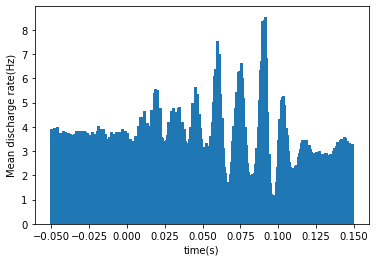

In [336]:
# plt.hist(dists1,bins=100,alpha=0.5);
H, bins = np.histogram(dist_in_time[times[-1]],bins=250);
plt.bar(bins[:-1],H/(time_range*10),width=(1/(len(bins)*1.9)))
plt.xlabel("time(s)")
plt.ylabel("Mean discharge rate(Hz)")
#plt.title("PSTH of network response")
plt.show()

In [127]:

moyenne_plus = np.mean(H) + np.std(H)
delimiters = []
moyenne = np.mean(H)

for bn in range(len(H)):
    
    value = H[bn]
    
    if value > moyenne_plus:

        left = bn
        while H[left]<= H[left+1] or H[left]>moyenne:
            left-=1
            
        right = bn
        while H[right]<= H[right-1] or H[right]>moyenne:
            right+=1
    
        delimiters.append((left,right))

IndexError: index 250 is out of bounds for axis 0 with size 250

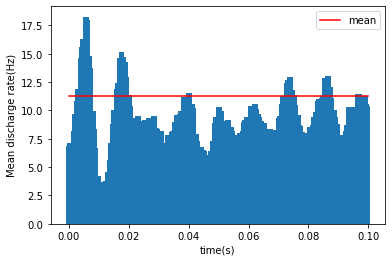

In [128]:

plt.bar(bins[:-1],H/(time_range*5),width=(1/(len(bins)*2)))
plt.xlabel("time(s)")
plt.ylabel("Mean discharge rate(Hz)")
#plt.title("PSTH of network response")
plt.plot([np.min(bins),np.max(bins)],[moyenne_plus/(time_range*5),moyenne_plus/(time_range*5)],c="red",label="mean")
plt.legend()

In [129]:
pics_bins = np.array(list(set(delimiters)))
pics_bins_changed = np.array([pics_bins[:,0],pics_bins[:,1]]).T
times_pics = bins[:-1][pics_bins_changed]

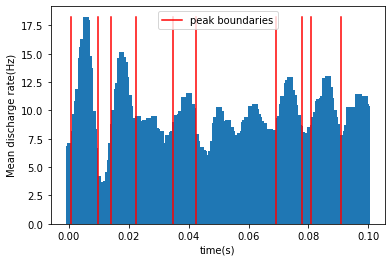

In [130]:
plt.bar(bins[:-1],H/(time_range*5),width=(1/(len(bins)*2)))
higher=np.max(H)/(time_range*5)
plt.xlabel("time(s)")
plt.ylabel("Mean discharge rate(Hz)")
i = times_pics.ravel()[0]
plt.plot([i,i],[0,higher],c="red",label="peak boundaries")
for i in times_pics.ravel()[1:]:
    plt.plot([i,i],[0,higher],c="red")
plt.legend()

In [131]:
spikes =  spikes_in_time[times[-1]]

In [132]:
ListTrains = [[] for _ in range(nb_neurons)] 
for s in spikes:
    ListTrains[int(s[1])].append(s[0])

In [133]:
distancesN = data_in_time[times[-1]]

In [134]:
scores = np.array([ np.sum(np.logical_and(np.array(x)[:,0]<duree_pattern,np.array(x)[:,0]>0))/len(x) if len(x)>0 else 0 for x in distancesN])

In [151]:
show_hist_times(dist_in_time,times)

In [31]:
proportion_in_time_signals = dict()
proportion_in_time = dict()
for i in range(nb_signal):
    print(i)
    which_signal=i
    spikes_in_time = all_spikes_in_time[which_signal]
    dist_in_time = all_dist_in_time[which_signal]
    times_in_time = all_times_in_time[which_signal]
    data_in_time = all_data_in_time[which_signal]

    proportion_in_time = dict()
    for t in times:
        #print(t)
        proportion_in_time[t]=tools.in_pattern_proportion_neurons(spikes_in_time[t],duree_pattern,np.array(signals_times[which_signal]),nb_neurons)
    proportion_in_time_signals[i]=proportion_in_time


0


In [32]:
proportion_in_time_signals_arrays = dict()
for k in proportion_in_time_signals:
    proportion_in_time_signals_arrays[k] = np.array(list(proportion_in_time_signals[k].values()))

In [33]:
Nproportion_in_time_signals_arrays = dict()
for k in proportion_in_time_signals:
    Nproportion_in_time_signals_arrays[k] = proportion_in_time_signals_arrays[k]/(duree_pattern*5)

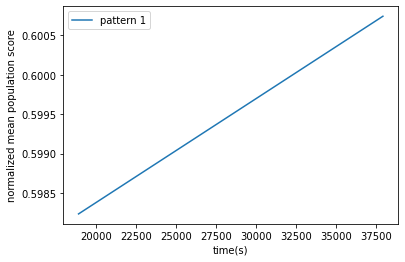

In [34]:
plt.plot(times,np.nanmean(proportion_in_time_signals_arrays[0],axis=1),label="pattern 1")
#plt.plot(times,np.mean(Nproportion_in_time_signals_arrays[1],axis=1),label="pattern 2")
# plt.plot(times,np.mean(proportion_in_time_signals_arrays[2],axis=1),label="pattern 1")
# plt.plot(times,np.mean(proportion_in_time_signals_arrays[3],axis=1),label="pattern 2")
plt.xlabel("time(s)")
plt.ylabel("normalized mean population score")
plt.legend()

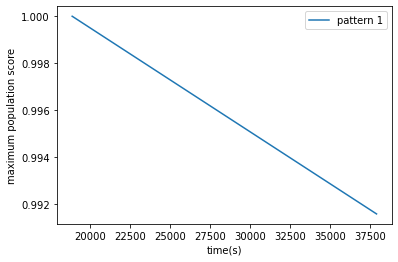

In [35]:
plt.plot(times,np.nanmax(proportion_in_time_signals_arrays[0],axis=1),label="pattern 1")
#plt.plot(times,np.max(proportion_in_time_signals_arrays[1],axis=1),label="pattern 2")
# plt.plot(times,np.max(proportion_in_time_signals_arrays[2],axis=1),label="pattern 1")
# plt.plot(times,np.max(proportion_in_time_signals_arrays[3],axis=1),label="pattern 2")
plt.xlabel("time(s)")
plt.ylabel("maximum population score")
plt.legend()


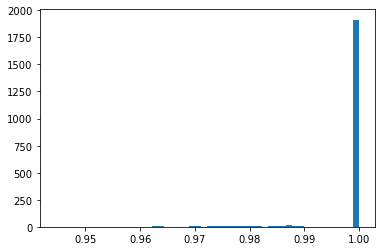

In [36]:
plt.hist(scores,bins=50);

In [37]:
score0=scores

In [38]:
score1 = scores

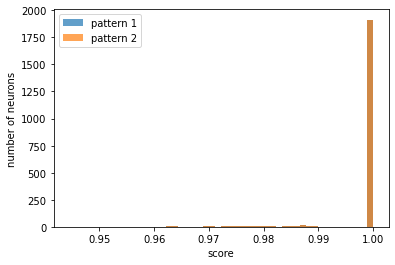

In [39]:
plt.hist(score0,bins=50,alpha=0.7,label="pattern 1");
plt.hist(score1,bins=50,alpha=0.7,label="pattern 2");
plt.xlabel("score");
plt.ylabel("number of neurons");
plt.legend();

In [40]:
the_one = np.argmax(scores)

In [41]:
distTrainOne = np.array(distancesN[the_one])

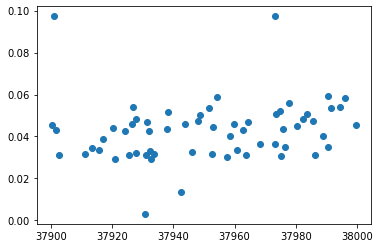

In [42]:
plt.scatter(distTrainOne[:,1],distTrainOne[:,0])

In [43]:
the_ones = np.where(scores>0.90)[0]
print(len(the_ones))

2048


In [44]:
dists_ones_n =dict()
dists_ones = dict()
for n in the_ones:
    dists_ones_n[n]=dict()
    
for t in times:
    dists_ones[t]= np.array([])
    for n in the_ones:
        dat = np.array(data_in_time[t][n])[:,0]
        dists_ones_n[n][t]=dat
        dists_ones[t] = np.append(dists_ones[t],dat)

In [47]:
len(dists_ones[times[0]])

128564

### Hist of pics

In [48]:
which_signal=0
spikes_in_time = all_spikes_in_time[which_signal]
dist_in_time = all_dist_in_time[which_signal]
times_in_time = all_times_in_time[which_signal]
data_in_time = all_data_in_time[which_signal]

In [49]:
Htot, bins = np.histogram(dist_in_time[times[-1]],bins=250);


In [50]:
moyenne_plus = np.mean(Htot) + 1*np.std(Htot)
delimiters = []
moyenne = np.mean(Htot)

for bn in range(len(Htot)):
    
    value = Htot[bn]

    if value > moyenne_plus:

        left = bn
        while not left<0 and (Htot[left]<= Htot[left+1] or Htot[left]>moyenne) :
            left-=1
            
        right = bn
        while not right>=len(Htot) and ( Htot[right]<= Htot[right-1] or Htot[right]>moyenne):
            right+=1
    
        delimiters.append((left,right))
            

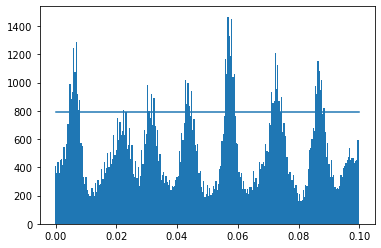

In [51]:

plt.bar(bins[:-1],Htot,width=size_window/(len(bins)-1))
plt.plot([np.min(bins),np.max(bins)],[moyenne_plus,moyenne_plus])


In [52]:
pics_bins = np.array(list(set(delimiters)))
pics_bins_changed = np.array([pics_bins[:,0],pics_bins[:,1]]).T
times_pics = bins[:-1][pics_bins_changed]
times_pics=times_pics[np.argsort(times_pics[:,0])]

In [53]:
pics_bins_changed

array([[206, 227],
       [174, 191],
       [102, 119],
       [132, 153],
       [  5,  25],
       [ 45,  66],
       [ 68,  86]])

In [54]:
distancesN
distancesN = data_in_time[times[-1]]
scores_pics = []
for tms in times_pics:
    scores_pics.append(np.array([ np.sum(np.logical_and(np.array(x)[:,0]<tms[1],np.array(x)[:,0]>tms[0]))/len(x) if len(x)>0 else 0 for x in distancesN]))



In [55]:
percentage_pic = []
for tms in times_pics:
    percentage_pic.append((tms[1]-tms[0])/size_window)

In [56]:
in_pics = []
for i in range(len(percentage_pic)):
    perc = percentage_pic[i]
    pic_ones = []
    for j in range(len(scores_pics[i])):
        score = scores_pics[i][j]
        if score > perc*2: # CHANGED
            pic_ones.append(j)
    in_pics.append(pic_ones)

In [57]:
def take_spikes_pics(distancesN):
    spikes_in_pics = []
    for pic_ones in in_pics:
        spikes_in_pics.append(np.array([]))
        for one in pic_ones :
            train = np.array(distancesN[one])[:,0]
            spikes_in_pics[-1]=np.append(spikes_in_pics[-1],train)
    return spikes_in_pics
spikes_in_pics=take_spikes_pics(distancesN)


<BarContainer object of 250 artists>

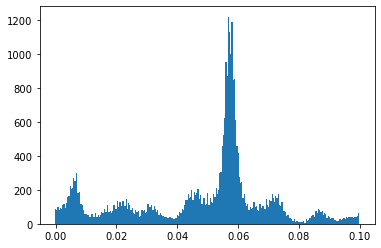

In [64]:
which_pic=4
H, bins = np.histogram(spikes_in_pics[which_pic],bins=250);

plt.bar(bins[:-1],H,width=size_window/(len(bins)-1))


<BarContainer object of 250 artists>

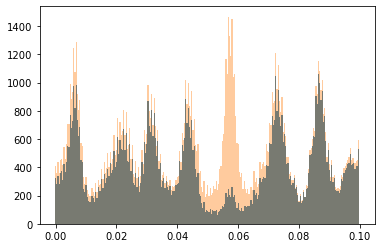

In [65]:
plt.bar(bins[:-1],Htot-H,width=size_window/(len(bins)-1))
plt.bar(bins[:-1],Htot,width=size_window/(len(bins)-1),alpha=0.4)

In [405]:

# fig, axis = plt.subplots(3,2, sharex=True)
# for i in range(1,7):
#     H, bins = np.histogram(spikes_in_pics[i],bins=250);
# #     axis[i/2,i%2].bar(bins[:-1],H,width=(1/(len(bins)*2)))
#     H_removed = Htot-H
#     axis[int(i/2),int(i%2)].bar(bins[:-1],H_removed,width=(1/(len(bins)*2)))
# fig.show()


Text(0, 0.5, 'Mean discharge rate(Hz)')

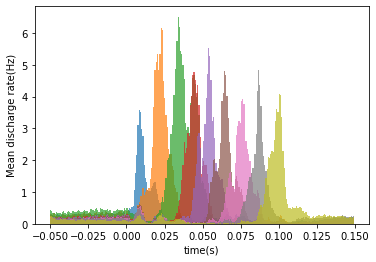

In [213]:
somme=0
somme_hist = np.zeros(250)
for which_pic in range(len(percentage_pic)):
    H, bins = np.histogram(spikes_in_pics[which_pic],bins=250);
    somme += np.sum(H)
    somme_hist += H
    plt.bar(bins[:-1],H/(time_range*5),width=(size_window/(len(bins)-1)),alpha=0.7)

plt.xlabel("time(s)")
plt.ylabel("Mean discharge rate(Hz)")

In [80]:
# plt.bar(bins[:-1],np.clip(Htot-somme_hist,0,None),width=(1/(len(bins)*3)));
# plt.xlabel("time(s)")
# plt.ylabel("Mean discharge rate(Hz)")

<BarContainer object of 250 artists>

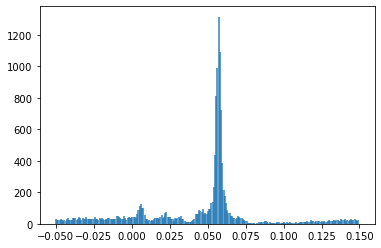

In [152]:
plt.bar(bins[:-1],H,width=(1/(len(bins)*3)),alpha=0.7)

In [280]:
print("Spikes represent "+str((somme/np.sum(Htot))*100)+"% of the activity")

Spikes represent 68.98866135877816% of the activity


In [ ]:
50/15

In [ ]:
fig, axis = plt.subplots(3,2, sharex=True,sharey=True)
i=0
fig.set_figheight(10)
fig.set_figwidth(10)
for t in times[::-15]:
    print(i)
    ditance_neurons = data_in_time[t]
    spikes_in_pics=take_spikes_pics(ditance_neurons)
    for which_pic in range(len(percentage_pic)):
        H, bins = np.histogram(spikes_in_pics[which_pic],bins=250);
        axis[int(i/2),(i%2)].bar(bins[:-1],H/time_range,width=(1/(len(bins)*3)))
    
    i+=1
fig.text(0.5,0.04, "time(s)", ha="center", va="center")
fig.text(0.05,0.5, "Mean discharge rate(Hz)", ha="center", va="center", rotation=90)


fig.show()

In [ ]:
def mean_std_neu(which_signal):
    mean_std_neurons = []
    std_neurones =dict()
    for t in times:
        #print(t)
        std_n = []
        for n in range(nb_neurons):
            std_n.append(np.nanstd(all_data_in_time[which_signal][t][n][:,0]))
        std_neurones[t]= np.array(std_n)
        #print(std_neurones)
        mean_std_neurons.append(np.nanmean(std_neurones[t]))
    return mean_std_neurons,std_neurones


In [ ]:
std_pat_1,std_neurones_1 = mean_std_neu(0)
#std_pat_2,std_neurones_2 = mean_std_neu(1)

In [ ]:
plt.plot(times,std_pat_1,label = "pattern 1")
#plt.plot(times,std_pat_2,label = "pattern 2")
plt.legend()
plt.title("mean std in time of each neurones")

In [77]:
#show_hist_times(std_neurones_1,times)

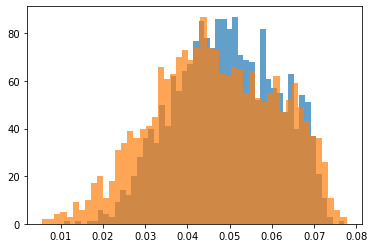

In [702]:
plt.hist(std_neurones_1[times[-1]],bins=50,alpha= 0.7);
plt.hist(std_neurones_1[times[0]],bins=50,alpha= 0.7);


In [703]:
last_signals = signals_times[which_signal][-1000:]
all_data = []
for event_i in range(len(last_signals)):
    pat_start = last_signals[event_i]
    all_data.append(sfo.get_spikes(pat_start-(duree_pattern/2),pat_start+duree_pattern+(duree_pattern/2)))
    
len_datas = np.array([len(i) for i in all_data])
len_in_pics = np.array([len(i) for i in in_pics])

np_in_pics = np.empty((len(in_pics),np.max(len_in_pics)))
np_all_data = np.empty((len(last_signals),np.max(len_datas),2))

for p in range(len(in_pics)):
    np_in_pics[p][:len_in_pics[p]]=in_pics[p]

for d in range(len(last_signals)):
    np_all_data[d,:len_datas[d]] = np.array(all_data[d])

def function():
    all_std = [[] for _ in range(len(np_in_pics))]
    for event_i in range(len(np_all_data)):
        #print(event_i)
        data = np_all_data[event_i][:len_datas[event_i]]
        pics_spikes =[]
        for i_pics in range(len(np_in_pics)):
            neurones = np_in_pics[i_pics][:len_in_pics[i_pics]]
            #times_pic = times_pics[i_pics]
            is_in = np.isin(data[:,1],neurones)
            #print(is_in)
            pic_spikes = []
            for d in range(len(data)) :
                if is_in[d]:
                    pic_spikes.append(data[d][0])
                    
            all_std[i_pics].append(np.std(pic_spikes))
    return all_std

### La STD de toutes les spikes sur un grand nombre de pattern est equivalente à la STD moyenne sur un grand nombre de patterns 

In [704]:
all_std = function()

In [705]:
np.array([np.std(i) for i in spikes_in_pics])

array([0.05837103, 0.05163684, 0.04695794, 0.0459199 , 0.04846805,
       0.04655934, 0.05063541, 0.04513883])

In [706]:
np.mean(all_std,axis=1)

array([0.05598421, 0.05096281, 0.04641741, 0.04547409, 0.04817833,
       0.04600011, 0.04978213, 0.0445777 ])

## spiking rate of assembly neurons 

In [14]:
NE = 2048
total_time = 38000
trange = 100
numberof = 10
for t in range(int(total_time/numberof),total_time,int(total_time/numberof)):
    times, cells = np.array(sfo.get_spikes(t_start=t,t_stop=t+(trange/numberof))).T
    freqs = []
    cvs = []
    for i in range(NE):
        if i in in_pics[6]:
            isi = np.diff(times[cells==i])
            isim = isi.mean()
            freqs.append(1/isim)
            cvs.append(isi.std()/isim)
    plt.hist(freqs,bins=50,log=True)
    plt.show()

NameError: name 'in_pics' is not defined

In [708]:
np.mean(freqs)

1.349922549421184

## Load and analyze EE weights

In [71]:
wmatfiles  = ["%s/rf1.%i.ee.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
w = np.sum( [ mmread(wf) for wf in wmatfiles ] )

In [72]:
wmatfilesext  = ["%s/rf1.%i.ext.wmat"%(datadir,i) for i in range(num_mpi_ranks)]
wext = np.sum( [ mmread(wf) for wf in wmatfilesext ] )

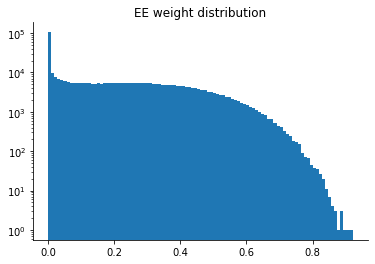

In [73]:
h1 = plt.hist(w.data, bins=100, log=True)
plt.title("EE weight distribution")
sns.despine()


In [74]:
net = Network(notebook=True)
mean_weight = np.mean(w.data)

In [75]:
def connectivity(neurones):
    connectivity_pat =[]
    bon_poids=[]
    for n in neurones:
        for n2 in neurones:
            if w[n,n2]>0:
#                 if w[n,n2]>mean_weight:
#                     bon_poids.append(w[n,n2])
                    #net.add_edge(int(n), int(n2), weight=float(w[n,n2]))
                connectivity_pat.append([n,n2,w[n,n2]])
    return np.array(connectivity_pat)
def connectivity_two(neurones1,neurones2,the_w):
    connectivity_pat =[]
    bon_poids=[]
    for n in neurones1:
        for n2 in neurones2:
            if the_w[n,n2]>0:
#                 if w[n,n2]>mean_weight:
#                     bon_poids.append(w[n,n2])
#                     #net.add_edge(int(n), int(n2), weight=float(w[n,n2]))
                connectivity_pat.append([n,n2,the_w[n,n2]])
    return np.array(connectivity_pat)    

In [76]:
len(in_pics[2])

431

In [78]:
#connectivity_pat = connectivity_two(in_pics[2],in_pics[1])

In [80]:
#print("Mean excitatory weight of "+str(np.mean(connectivity_pat[:,2]))+" for coding neurons vs "+str(mean_weight)+" for all neurons")

In [82]:
#plt.hist(connectivity_pat[:,2],bins=50,log=True);

## synaptic weight analysis

In [83]:
spikes_rast= []
with open(datadir+'/spiketrains_0') as f:
    
    while line := f.readline()[:-1].split(" "):
        if float(line[0])<signals_times[0][0]+duree_pattern:
            if float(line[0]) > signals_times[0][0]:
                spikes_rast.append([float(line[0])-signals_times[0][0],int(line[1])]) 
        else:
            break
spikes_rast = np.array(spikes_rast)

In [84]:
spikes_rast = np.array(spikes_rast)

In [85]:
spikes_rast

array([[1.000e-04, 1.678e+03],
       [1.000e-04, 1.782e+03],
       [2.000e-04, 2.100e+01],
       ...,
       [9.970e-02, 1.198e+03],
       [9.990e-02, 1.275e+03],
       [9.990e-02, 7.740e+02]])

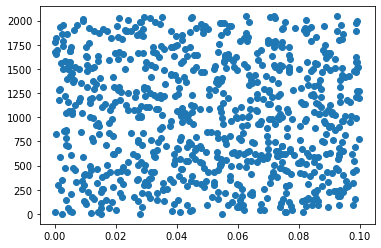

In [86]:
plt.scatter(spikes_rast[:,0],spikes_rast[:,1])

In [87]:
nbspike_peaks = tools.in_events_nbspike_neurons(spikes_rast, times_pics[:,0],times_pics[:,1],1024)

In [88]:
np.sum(nbspike_peaks[2])

88.0

In [89]:
which_peak=4

In [90]:
neurons_id_nbspikes = dict()
for i in set(nbspike_peaks[which_peak]) :
    neurons_id_nbspikes[i] = np.where(nbspike_peaks[which_peak]==i)[0]

In [91]:
connectivity_nb_spikes = dict()
for k in neurons_id_nbspikes:
    connectivity_nb_spikes[str(k)] = np.mean(connectivity_two(neurons_id_nbspikes[k],in_pics[which_peak],wext)[:,2])


In [92]:
connectivity_nb_spikes

{'0.0': 0.4088669705449239,
 '1.0': 0.5556981073576513,
 '2.0': 0.680833497836187}

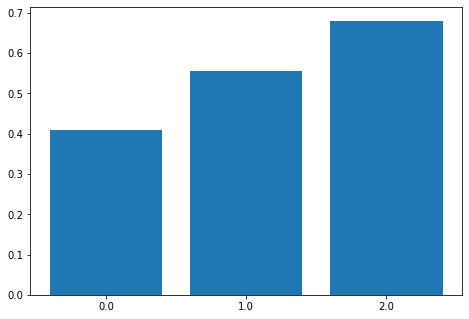

In [93]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
nb_spikes = list(connectivity_nb_spikes.keys())
mean_strenght =list(connectivity_nb_spikes.values())
ax.bar(nb_spikes,mean_strenght)
plt.show()

## Suite ...

In [94]:
import copy

In [95]:
nb_bins = 60

In [96]:
# neuron_hist = [[] for n in range(nb_neurons)]
# for n in range(nb_neurons):
#     data = np.histogram(distancesN[n][:,0],bins=nb_bins)
#     neuron_hist[n]= data[0]
#     times = data[1]

In [97]:
nb_stim = 2048

In [98]:
stim_activity = [[] for n in range(nb_stim)]
for spk in spikes_rast:
    stim_activity[int(spk[1])].append(spk[0])

stim_hist = [[] for n in range(nb_stim)]
times_field = np.linspace(0,duree_pattern,nb_bins+1)

for n in range(nb_stim):
    histo = np.zeros(nb_bins)
    for spk in stim_activity[n]:
        tims = spk
        histo[int((spk*nb_bins)/duree_pattern)]+=1
    stim_hist[n]= histo


In [99]:
stim_hist = np.array(stim_hist)
#neuron_hist = np.array(neuron_hist)

In [100]:
range(nb_stim)[-1]

2047

In [101]:
cnt = []
for n in range(nb_neurons):
    print(n)
    cnt.append(connectivity_two(range(nb_stim), [n],wext))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047


In [102]:
sensible_fields = []
for n in range(nb_neurons):
    receptiv_field = cnt[n][:,0]
    weights_field = cnt[n][:,2]
    sensible_field=[]
    for n2 in range(len(receptiv_field)):
        sensible_field.append(stim_hist[int(receptiv_field[n2])]*weights_field[n2])
    sensible_fields.append(np.sum(sensible_field,axis=0))

In [103]:
sensible_fields = np.array(sensible_fields)

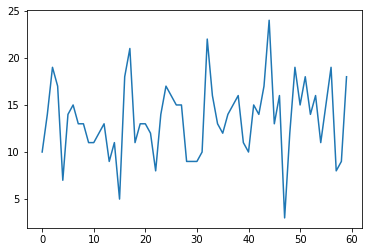

In [104]:
plt.plot(np.sum(stim_hist,axis=0))

In [105]:
np.sum(stim_hist,axis=1)

array([1., 1., 1., ..., 1., 0., 0.])

In [106]:
len(times_field)

61

In [107]:
len(sensible_fields[2])

60

<BarContainer object of 60 artists>

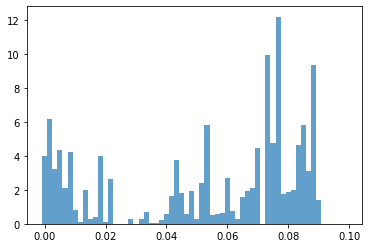

In [108]:
plt.bar(times_field[:-1],sensible_fields[8],width=(duree_pattern/(nb_bins)),alpha=0.7)

In [130]:
which_peak =6

In [131]:
np.sum(sensible_fields[in_pics[which_peak]],axis=0)

array([ 663.05944751,  904.87801251, 1083.74051892,  849.74605402,
        215.29792005,  523.75258637,  588.00257122,  508.39459523,
        650.71808527,  585.77274203,  537.61381722,  740.26611092,
        680.56243303,  474.78618622,  431.97126491,  243.97379568,
        866.20696403, 1114.50360604,  371.35044459,  612.51411035,
        475.91992941,  489.26530186,  359.91774044,  565.8833182 ,
        717.80068735,  573.47903027,  620.36728867,  680.3172195 ,
        364.97294573,  403.39467372,  380.03172384,  538.04768348,
       1251.40815681,  829.89919065,  598.54620048,  681.19872406,
        814.99673512,  950.29725033, 1146.56787661,  675.27955179,
        646.42795771, 1122.81470406, 1096.99892313, 1313.43214836,
       2323.20278689, 1256.33643489, 1524.26223087,  333.33325266,
       1253.53406302, 2323.60109053, 1680.04982007, 1569.27821414,
        879.04647328,  685.0865356 ,  542.38530725,  633.61093991,
        833.98831108,  290.23239904,  304.67428112,  628.16384

<BarContainer object of 60 artists>

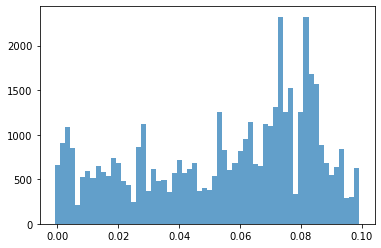

In [132]:
plt.bar(times_field[:-1],np.sum(sensible_fields[in_pics[which_peak]],axis=0),width=(duree_pattern/(nb_bins)),alpha=0.7)

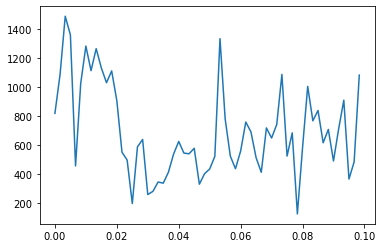

In [525]:
plt.plot(times_field[:-1],np.sum(sensible_fields[in_pics[which_peak]],axis=0))

## Neurons in time 

In [134]:
import copy

In [135]:
nb_bins = 30

In [136]:
nb_neurons

2048

In [137]:
neuron_hist = [[] for n in range(nb_neurons)]
for n in range(nb_neurons):
    data = np.histogram(distancesN[n][:,0],bins=nb_bins)
    neuron_hist[n]= data[0]
    times = data[1]

In [138]:
neuron_hist_prev = np.array(neuron_hist)

In [139]:
neuron_hist_prev

array([[ 1,  0,  0, ...,  0,  0,  2],
       [ 2,  3,  0, ...,  7,  4,  3],
       [ 3,  1,  0, ...,  1,  1,  2],
       ...,
       [ 2, 11, 23, ...,  0,  1, 10],
       [ 3,  1,  2, ...,  3,  0,  1],
       [ 4,  1,  0, ...,  1,  0,  1]])

In [140]:
sum_of_rows = neuron_hist_prev.sum(axis=1)
neuron_hist = neuron_hist_prev / sum_of_rows[:, np.newaxis]

In [141]:
sum_of_rows

array([62, 98, 23, ..., 65, 76, 16])

In [142]:
neuron_hist = list(neuron_hist)

In [143]:
ordered_neuron_hist = []
min_activity_neuron= np.argmin(np.sum(neuron_hist_prev,axis=1) )
actual = neuron_hist[min_activity_neuron]
neuron_hist_copy = copy.deepcopy(neuron_hist)
neuron_hist_copy.pop(min_activity_neuron)
ordered_neuron_hist.append(actual)
while len(neuron_hist_copy)>0:
    next_one = np.argmin((np.sum(np.abs(neuron_hist_copy - actual),axis=1)))
    ordered_neuron_hist.append(neuron_hist_copy[next_one])
    actual = neuron_hist_copy[next_one]
    neuron_hist_copy.pop(next_one)

In [144]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [145]:
clustering = KMeans(len(in_pics)+1).fit_predict(neuron_hist)

In [146]:
set(clustering)

{0, 1, 2, 3, 4, 5, 6, 7}

In [185]:
cluster = 0

In [186]:
dist_clust = []
all_dist_clust = np.array([])
for n in range(nb_neurons):
    if clustering[n]==cluster:
        dist_clust.append(distancesN[n][:,0])
        all_dist_clust = np.append(all_dist_clust,distancesN[n][:,0])

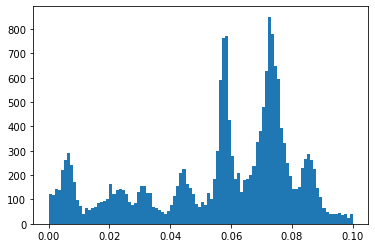

In [187]:
plt.hist(all_dist_clust,bins=100);

In [188]:
neuron_hist_cluster = [[] for n in range(nb_neurons)]
id_neuron=[]
for n in range(nb_neurons):
    if n in np.where(clustering==cluster)[0]:
        data = np.histogram(distancesN[n][:,0],bins=nb_bins)
        neuron_hist_cluster[n]= data[0]
        times_cluster = data[1] 
        id_neuron.append(n)

In [189]:
neuron_hist_cluster = [i for i in neuron_hist_cluster if len(i)>0]

In [192]:
clustering_cluster  = KMeans(3).fit_predict(neuron_hist_cluster)

In [193]:
clustering_cluster

array([1, 1, 0, 0, 1, 1, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 1, 2, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 2, 2, 1, 1,
       0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 2, 0, 1, 1, 0, 2, 0, 0, 0, 0,
       2, 0, 1, 0, 1, 2, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 1, 1, 2, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0, 2, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2,
       0, 0, 1, 1, 0, 2, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 0, 2, 0, 2, 0, 2,
       1, 2, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 2, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2, 0, 2,
       0, 1, 0, 0, 1, 1, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1],
      dtype=int32)

In [230]:
sub_clus = 1
dist_clust_clust = []
all_dist_clust_clust = np.array([])
for cl in range(len(clustering_cluster)):
    if clustering_cluster[cl] == sub_clus:
        dist_clust_clust.append(distancesN[id_neuron[cl]][:,0])
        all_dist_clust_clust = np.append(all_dist_clust_clust,distancesN[id_neuron[cl]][:,0])

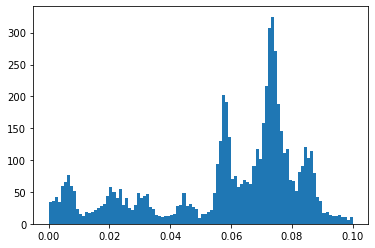

In [231]:
plt.hist(all_dist_clust_clust,bins=100);

In [ ]:
plt.hist(all_dist_clust_clust,bins=100);